In [1]:
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.contrib import rnn
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.layers import *
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 검증 옵션

EarlyStopping()

Train on 700 samples, validate on 300 samples
Epoch 1/1000
700/700 [==============================] - 0s 290us/step - loss: 1.8299 - acc: 0.2314 - val_loss: 1.8781 - val_acc: 0.2000
Epoch 2/1000
700/700 [==============================] - 0s 141us/step - loss: 1.8258 - acc: 0.2471 - val_loss: 1.8759 - val_acc: 0.1833
Epoch 3/1000
700/700 [==============================] - 0s 135us/step - loss: 1.8217 - acc: 0.2343 - val_loss: 1.8688 - val_acc: 0.2000
Epoch 4/1000
700/700 [==============================] - 0s 135us/step - loss: 1.8185 - acc: 0.2443 - val_loss: 1.8700 - val_acc: 0.2000
Epoch 5/1000
700/700 [==============================] - 0s 143us/step - loss: 1.8146 - acc: 0.2443 - val_loss: 1.8695 - val_acc: 0.1900
Epoch 6/1000
700/700 [==============================] - 0s 140us/step - loss: 1.8111 - acc: 0.2457 - val_loss: 1.8650 - val_acc: 0.1733
Epoch 7/1000
700/700 [==============================] - 0s 142us/step - loss: 1.8077 - acc: 0.2486 - val_loss: 1.8621 - val_acc: 0.1700
Ep

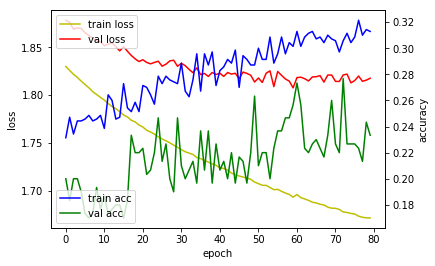

In [37]:
np.random.seed(3)

# 1. 데이터셋 준비하기

# 훈련셋과 시험셋 로딩
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 훈련셋과 검증셋 분리
X_val = X_train[50000:]
Y_val = Y_train[50000:]
X_train = X_train[:50000]
Y_train = Y_train[:50000]

X_train = X_train.reshape(50000, 784).astype('float32') / 255.0
X_val = X_val.reshape(10000, 784).astype('float32') / 255.0
X_test = X_test.reshape(10000, 784).astype('float32') / 255.0

# 훈련셋, 검증셋 고르기
train_rand_idxs = np.random.choice(50000, 700)
val_rand_idxs = np.random.choice(10000, 300)

X_train = X_train[train_rand_idxs]
Y_train = Y_train[train_rand_idxs]
X_val = X_val[val_rand_idxs]
Y_val = Y_val[val_rand_idxs]

# 라벨링 전환
Y_train = np_utils.to_categorical(Y_train)
Y_val = np_utils.to_categorical(Y_val)
Y_test = np_utils.to_categorical(Y_test)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(units=2, input_dim=28*28, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

# 3. 모델 엮기
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 4. 모델 학습시키기
from keras.callbacks import EarlyStopping
es = EarlyStopping(patience=20)    # 조기 종료 콜백함수 객체
hist = model.fit(X_train, Y_train, epochs=1000, batch_size=10, validation_data=(X_val, Y_val), callbacks=[es])

# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# Stacked RNN

In [6]:
sentence = ("The regret after not doing something is bigger than that of doing something "
            "Ability is decided by one's own effort "
            "The difficulty in life is the choice.")
sentence

"The regret after not doing something is bigger than that of doing something Ability is decided by one's own effort The difficulty in life is the choice."

In [0]:
import tensorflow as tf
from tensorflow.contrib import rnn

In [11]:
charSet = list(set(sentence))
charSet

['d',
 "'",
 'm',
 'h',
 'g',
 'T',
 ' ',
 'l',
 'o',
 'y',
 'w',
 '.',
 'a',
 'n',
 'f',
 't',
 's',
 'e',
 'r',
 'u',
 'i',
 'b',
 'c',
 'A']

In [12]:
charDic = {w:i for i, w in enumerate(charSet)}
charDic

{' ': 6,
 "'": 1,
 '.': 11,
 'A': 23,
 'T': 5,
 'a': 12,
 'b': 21,
 'c': 22,
 'd': 0,
 'e': 17,
 'f': 14,
 'g': 4,
 'h': 3,
 'i': 20,
 'l': 7,
 'm': 2,
 'n': 13,
 'o': 8,
 'r': 18,
 's': 16,
 't': 15,
 'u': 19,
 'w': 10,
 'y': 9}

In [14]:
data_dim = len(charDic)    # input_dim = 24차원
data_dim    # 24

24

In [0]:
num_classes = hidden_size = data_dim    # 24

In [0]:
sequence_length = 10    # 임의로 10으로 선정
learning_rate = 0.1

In [17]:
len(sentence)    # 152글자

152

In [19]:
for i in range(0, len(sentence)-sequence_length):    # (0, 152-10) => (0, 142)
  xstr = sentence[i:i+sequence_length]    # 0~9번 인덱스에 해당하는 문자들 ...
  ystr = sentence[i+1:i+sequence_length+1]    # 1~10번 인덱스에 해당하는 문자들 ...
  print(i, "|", xstr, "|", ystr)

0 | The regret | he regret 
1 | he regret  | e regret a
2 | e regret a |  regret af
3 |  regret af | regret aft
4 | regret aft | egret afte
5 | egret afte | gret after
6 | gret after | ret after 
7 | ret after  | et after n
8 | et after n | t after no
9 | t after no |  after not
10 |  after not | after not 
11 | after not  | fter not d
12 | fter not d | ter not do
13 | ter not do | er not doi
14 | er not doi | r not doin
15 | r not doin |  not doing
16 |  not doing | not doing 
17 | not doing  | ot doing s
18 | ot doing s | t doing so
19 | t doing so |  doing som
20 |  doing som | doing some
21 | doing some | oing somet
22 | oing somet | ing someth
23 | ing someth | ng somethi
24 | ng somethi | g somethin
25 | g somethin |  something
26 |  something | something 
27 | something  | omething i
28 | omething i | mething is
29 | mething is | ething is 
30 | ething is  | thing is b
31 | thing is b | hing is bi
32 | hing is bi | ing is big
33 | ing is big | ng is bigg
34 | ng is bigg | g is b

In [21]:
for i in range(0, len(sentence)-sequence_length):    # (0, 152-10) => (0, 142)
  xstr = sentence[i:i+sequence_length]    # 0~9번 인덱스에 해당하는 문자들 ...
  ystr = sentence[i+1:i+sequence_length+1]    # 1~10번 인덱스에 해당하는 문자들 ...
  x = [charDic[c] for c in xstr]
  y = [charDic[c] for c in ystr]
  print(x)
  print(y)
  print("="*20)

[5, 3, 17, 6, 18, 17, 4, 18, 17, 15]
[3, 17, 6, 18, 17, 4, 18, 17, 15, 6]
[3, 17, 6, 18, 17, 4, 18, 17, 15, 6]
[17, 6, 18, 17, 4, 18, 17, 15, 6, 12]
[17, 6, 18, 17, 4, 18, 17, 15, 6, 12]
[6, 18, 17, 4, 18, 17, 15, 6, 12, 14]
[6, 18, 17, 4, 18, 17, 15, 6, 12, 14]
[18, 17, 4, 18, 17, 15, 6, 12, 14, 15]
[18, 17, 4, 18, 17, 15, 6, 12, 14, 15]
[17, 4, 18, 17, 15, 6, 12, 14, 15, 17]
[17, 4, 18, 17, 15, 6, 12, 14, 15, 17]
[4, 18, 17, 15, 6, 12, 14, 15, 17, 18]
[4, 18, 17, 15, 6, 12, 14, 15, 17, 18]
[18, 17, 15, 6, 12, 14, 15, 17, 18, 6]
[18, 17, 15, 6, 12, 14, 15, 17, 18, 6]
[17, 15, 6, 12, 14, 15, 17, 18, 6, 13]
[17, 15, 6, 12, 14, 15, 17, 18, 6, 13]
[15, 6, 12, 14, 15, 17, 18, 6, 13, 8]
[15, 6, 12, 14, 15, 17, 18, 6, 13, 8]
[6, 12, 14, 15, 17, 18, 6, 13, 8, 15]
[6, 12, 14, 15, 17, 18, 6, 13, 8, 15]
[12, 14, 15, 17, 18, 6, 13, 8, 15, 6]
[12, 14, 15, 17, 18, 6, 13, 8, 15, 6]
[14, 15, 17, 18, 6, 13, 8, 15, 6, 0]
[14, 15, 17, 18, 6, 13, 8, 15, 6, 0]
[15, 17, 18, 6, 13, 8, 15, 6, 0, 8]
[15, 17, 

In [0]:
datax = []
datay = []

for i in range(0, len(sentence)-sequence_length):    # (0, 152-10) => (0, 142)
  xstr = sentence[i:i+sequence_length]    # 0~9번 인덱스에 해당하는 문자들 ...
  ystr = sentence[i+1:i+sequence_length+1]    # 1~10번 인덱스에 해당하는 문자들 ...
  x = [charDic[c] for c in xstr]
  y = [charDic[c] for c in ystr]
  datax.append(x)
  datay.append(y)

batch_size = len(datax)    # 142

In [0]:
tf.reset_default_graph()

x = tf.placeholder(tf.int32, [None, sequence_length])
y = tf.placeholder(tf.int32, [None, sequence_length])
x_one_hot = tf.one_hot(x, depth=num_classes)

def lstm_cell():
  cell = rnn.BasicLSTMCell(hidden_size)
  return cell
multi_cells = rnn.MultiRNNCell([lstm_cell() for _ in range(2)])    # cell 2개가 인수로 들어가게 된다    # 두겹으로 층 구성
outputs, _states = tf.nn.dynamic_rnn(multi_cells, x_one_hot, dtype=tf.float32)

xforfc = tf.reshape(outputs, [-1, hidden_size])    # fully connect 하기 위한 reshaping
outputs = tf.contrib.layers.fully_connected(xforfc, num_classes, activation_fn=None)    # num_classes만큼 최종 출력
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])    # 출력을 위해 다시 reshape

weights = tf.ones([batch_size, sequence_length])
sequence_loss = tf.contrib.seq2seq.sequence_loss(logits=outputs, targets=y, weights=weights)
meanLoss = tf.reduce_mean(sequence_loss)

train = tf.train.AdamOptimizer(learning_rate).minimize(meanLoss)

In [31]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(500):
  _, cv, res = sess.run([train, meanLoss, outputs], feed_dict={x:datax, y:datay})
  for j, result in enumerate(res):
    index = np.argmax(result, axis=1)
    # print(i, j, "".join([charSet[t] for t in index]), cv)

res = sess.run(outputs, feed_dict={x:datax})
# print(res)
for j, result in enumerate(res):
  index = np.argmax(result, 1)
  if j is 0:
    print("".join([charSet[t] for t in index]), end="")
  print(charSet[index[-1]], end="")

he regret  after not doing something is bigger than that of doing something ibility is decided by one's own effort The difficulty in life is the choice.

# keras를 이용한 LSTM 모델링으로 스팸메일 분류

## 0. 데이터 불러오기

In [0]:
import pandas as pd

In [41]:
data = pd.read_csv("/content/drive/My Drive/190000 멀티캠퍼스/Data/spam.csv", encoding="latin1")
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [0]:
# 필요없는 열 제거

del data["Unnamed: 2"]
del data["Unnamed: 3"]
del data["Unnamed: 4"]

In [43]:
data

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [44]:
# v1열에 ham은 0으로, spam은 1로 변경

data["v1"] = data["v1"].replace(["ham", "spam"], [0, 1])
data

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [45]:
# null 유무 확인

data.isnull().values.any()    # any(): 하나라도 있으면 출력

False

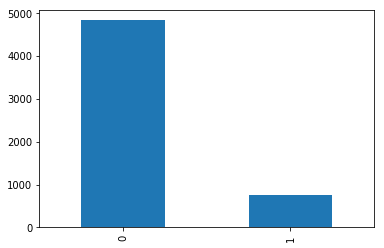

In [47]:
# 스팸메일과 햄메일의 분포 시각화

%matplotlib inline
import matplotlib.pyplot as plt

data["v1"].value_counts().plot(kind="bar")

In [48]:
# 데이터 추출

ydata = data["v1"]
xdata = data["v2"]

print(len(xdata))
print(len(ydata))

5572
5572


## 1. 문장을 단어 단위로 토큰화

In [0]:
from keras.preprocessing.text import Tokenizer

In [56]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(xdata)    # 각 행에 대한 토큰화 수행    # 코퍼스(딕셔너리 형태)가 만들어진다
word_index = tokenizer.word_index
word_index

{'i': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'the': 5,
 'u': 6,
 'and': 7,
 'in': 8,
 'is': 9,
 'me': 10,
 'my': 11,
 'for': 12,
 'your': 13,
 'it': 14,
 'of': 15,
 'call': 16,
 'have': 17,
 'on': 18,
 '2': 19,
 'that': 20,
 'now': 21,
 'are': 22,
 'so': 23,
 'but': 24,
 'not': 25,
 'or': 26,
 'do': 27,
 'can': 28,
 'at': 29,
 "i'm": 30,
 'get': 31,
 'be': 32,
 'will': 33,
 'if': 34,
 'ur': 35,
 'with': 36,
 'just': 37,
 'no': 38,
 'we': 39,
 'this': 40,
 'gt': 41,
 '4': 42,
 'lt': 43,
 'up': 44,
 'when': 45,
 'ok': 46,
 'free': 47,
 'from': 48,
 'how': 49,
 'go': 50,
 'all': 51,
 'out': 52,
 'what': 53,
 'know': 54,
 'like': 55,
 'good': 56,
 'then': 57,
 'got': 58,
 'was': 59,
 'come': 60,
 'its': 61,
 'am': 62,
 'time': 63,
 'only': 64,
 'day': 65,
 'love': 66,
 'there': 67,
 'send': 68,
 'he': 69,
 'want': 70,
 'text': 71,
 'as': 72,
 'txt': 73,
 'one': 74,
 'going': 75,
 'by': 76,
 'home': 77,
 "i'll": 78,
 'need': 79,
 'about': 80,
 'r': 81,
 'lor': 82,
 'sorry': 83,
 'stop': 84,
 'st

In [57]:
len(word_index)    # 8920개 = voc의 크기

8920

## 2. 단어 토큰을 정수로 인코딩

In [54]:
sequences = tokenizer.texts_to_sequences(xdata)    # 정수로 저장
sequences[:5]

[[50,
  469,
  4410,
  841,
  751,
  657,
  64,
  8,
  1324,
  89,
  121,
  349,
  1325,
  147,
  2987,
  1326,
  67,
  58,
  4411,
  144],
 [46, 336, 1495, 470, 6, 1929],
 [47,
  486,
  8,
  19,
  4,
  796,
  899,
  2,
  178,
  1930,
  1199,
  658,
  1931,
  2320,
  267,
  2321,
  71,
  1930,
  2,
  1932,
  2,
  337,
  486,
  554,
  955,
  73,
  388,
  179,
  659,
  389,
  2988],
 [6, 245, 152, 23, 379, 2989, 6, 140, 154, 57, 152],
 [1018, 1, 98, 107, 69, 487, 2, 956, 69, 1933, 218, 111, 471]]

In [59]:
len(sequences)    # 5572 = 행의 개수

5572

## 3. 데이터 정리

In [60]:
trainData = int(len(sequences)*0.8)
testData = int(len(sequences)-trainData)
print(trainData)    # 4457
print(testData)    # 1115

4457
1115


In [65]:
# 메일의 최대 길이 출력
print(max(len(d) for d in sequences))    # 189

# 메일의 평균 길이 출력
print(sum(map(len, sequences)) / len(sequences))    # 15.79

189
15.794867193108399


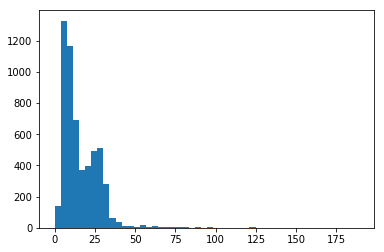

In [67]:
# 메일 제목 길이 시각화

xdata = sequences
plt.hist([len(s) for s in xdata], bins=50)
plt.show()

# 가장 긴 메일의 길이 = 189
# 그러나 분포를 보면 50 미만이 대부분 (그러므로 메모리를 고려한 작업을 하게 된다면 50 이상을 잘라버린다던지 다른 방법을 강구할 수 있다)

In [0]:
from keras.layers import *
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

In [0]:
vocab_size = len(word_index)+1    # 8920 + 1 = 8921

In [70]:
# 전체 데이터셋의 길이를 189로 통일

max_len = 189
data = pad_sequences(xdata, maxlen=max_len)    # 디폴트는 pre padding
data.shape

(5572, 189)

In [71]:
data[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [0]:
# train data, test data 나누기

xtest = data[trainData:]    # 뒤쪽 1115개
ytest = ydata[trainData:]

xtrain = data[:trainData]    # 앞쪽 4457개
ytrain = ydata[:trainData]

## 4. 모델 생성

In [0]:
tf.reset_default_graph()

sess = tf.Session()

# 밑에 fit함수에서 오류나서 이 코드 추가함. 참고: https://stackoverflow.com/questions/54652536/

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation="sigmoid"))

In [0]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

## 5. 모델 학습

In [87]:
with sess.as_default():
  with sess.graph.as_default():    # fit 함수에서 오류나서 이 코드 추가함. 참고: https://stackoverflow.com/questions/54652536/
    history = model.fit(xtrain, ytrain, epochs=5, batch_size=60, validation_split=0.2)

Train on 3565 samples, validate on 892 samples
Epoch 1/5
3565/3565 [==============================] - 3s 788us/step - loss: 0.2489 - acc: 0.9212 - val_loss: 0.1996 - val_acc: 0.9249
Epoch 2/5
3565/3565 [==============================] - 2s 635us/step - loss: 0.0920 - acc: 0.9739 - val_loss: 0.0789 - val_acc: 0.9776
Epoch 3/5
3565/3565 [==============================] - 2s 642us/step - loss: 0.0468 - acc: 0.9882 - val_loss: 0.0536 - val_acc: 0.9843
Epoch 4/5
3565/3565 [==============================] - 2s 646us/step - loss: 0.1100 - acc: 0.9571 - val_loss: 0.0984 - val_acc: 0.9720
Epoch 5/5
3565/3565 [==============================] - 2s 638us/step - loss: 0.0641 - acc: 0.9790 - val_loss: 0.0531 - val_acc: 0.9843


In [89]:
with sess.as_default():
  with sess.graph.as_default():
    model.evaluate(xtest, ytest)[1]

1115/1115 [==============================] - 0s 271us/step


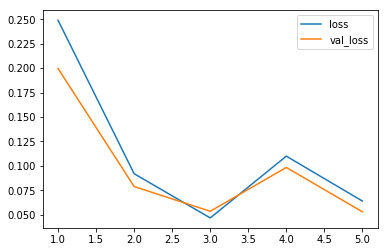

In [98]:
# epoch의 변화에 따른 loss 시각화
epochs = range(1, len(history.history["acc"])+1)
plt.plot(epochs, history.history["loss"], label="loss")
plt.plot(epochs, history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()